In [1]:
import numpy as np
import cv2 as cv
import argparse
import os.path

import matplotlib.pyplot as plt
%matplotlib inline

image path: sanjeev.jpg
Colorized image saved as sanjeev_colorized.png
Done !!!


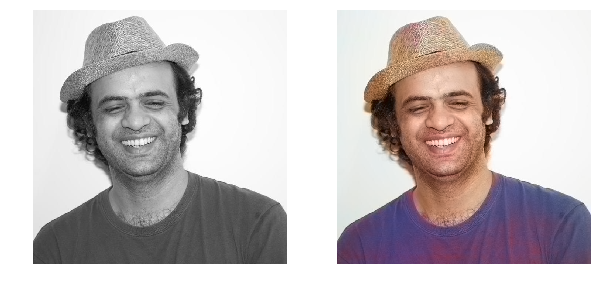

In [8]:
image_path = input("image path: ")
# Read the input image
frame = cv.imread(image_path)

# Specify the paths for the 2 model files
protoFile = "./models/colorization_deploy_v2.prototxt"
weightsFile = "./models/colorization_release_v2.caffemodel"
#weightsFile = "./models/colorization_release_v2_norebal.caffemodel"

# Load the cluster centers
pts_in_hull = np.load('./pts_in_hull.npy')

# Read the network into Memory
net = cv.dnn.readNetFromCaffe(protoFile, weightsFile)

# populate cluster centers as 1x1 convolution kernel
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

#from opencv sample
W_in = 224
H_in = 224

img_rgb = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
img_lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2Lab)
img_l = img_lab[:,:,0] # pull out L channel

# resize lightness channel to network input size
img_l_rs = cv.resize(img_l, (W_in, H_in)) #
img_l_rs -= 50 # subtract 50 for mean-centering

net.setInput(cv.dnn.blobFromImage(img_l_rs))
ab_dec = net.forward()[0,:,:,:].transpose((1,2,0)) # this is our result

(H_orig,W_orig) = img_rgb.shape[:2] # original image size
ab_dec_us = cv.resize(ab_dec, (W_orig, H_orig))
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_bgr_out = np.clip(cv.cvtColor(img_lab_out, cv.COLOR_Lab2BGR), 0, 1)

# save to file
outputFile = image_path[:-4]+'_colorized.png'
updated_frame = (img_bgr_out*255).astype(np.uint8)
cv.imwrite(outputFile, updated_frame)




_, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,10])

ax1.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
ax1.axis('off')

ax2.imshow(cv.cvtColor(updated_frame, cv.COLOR_BGR2RGB))
ax2.axis('off')

print('Colorized image saved as '+outputFile)
print('Done !!!')
